### Wstęp

Tematem niniejszej pracy jest problem znalezienia rozwiązania gry ***SameGame*** przez algorytm genetyczny.

***SameGame***, pierwotnie wydawana pod nazwą *Chain Shot!*, to gra logiczna stworzona w Japonii w 1985 roku przez Kuniakiego Moribe. W 1992 roku została przeniesiona na platformę Unix i od tego czasu funkcjonuje pod obecną nazwą. Rok później zadebiutowała na platformie Windows 3.1, gdzie otrzymała angielskie tłumaczenie.

#### Zasady
Plansza ***SameGame*** jest prostokątem losowo wypełnionym kafelkami o różnych kolorach (zazwyczaj od trzech do pięciu). Celem gry jest usunięcie wszystkich kafelków. Gracz wybiera kafelek, który jest usuwany wraz z jego wszystkimi sąsiadami o tym samym kolorze. Kafelki powyżej spadają, zajmując powstałe wolne miejsce. Usunięcie całej kolumny powoduje przesunięcie się pozostałych kolumn do lewej. Gra się kończy plansza jest pusta lub skończą się możliwe ruchy.

Przeprowadzane eksperymenty w dalszych rozdziałach uwzględniają podane parametry:
- wielkość planszy
- liczba kolorów
- limit ruchów

### Rozdział I

#### Generowanie planszy

Poniższa funkcja **GenerateBoard** generuje planszę *A* x *B*, wypełnioną *N* kolorami (max. 5) i przedstawia ją w postaci macierzy. Każdy kolor jest reprezentowany przez liczbę:
- 1 - zielony
- 2 - czerwony
- 3 - niebieski
- 4 - żółty
- 5 - różowy

Kolor czarny (0) oznacza puste miejsce.

In [1]:
import random

colorids = [1, 2, 3, 4, 5]

def GenerateBoard(a,b,n):
    if n > len(colorids):
        return []

    matrix = []
    for i in range(a):
        matrix.append([])
        for _ in range(b):
            matrix[i].append(colorids[random.randint(0,n-1)])
    return matrix

Wykorzystując powyższą funkcję wygenerowano po trzy plansze w trzech rozmiarach: - mała, średnia, duża - oraz kolejno trzech, czterech i pięciu kolorach, które reprezentują poziom trudności gry (łącznie dziewięć plansz).
- plansze małe (8x8)

In [2]:
boardsmall1 = GenerateBoard(8,8,3)
boardsmall2 = GenerateBoard(8,8,4)
boardsmall3 = GenerateBoard(8,8,5)

- plansze średnie (12x12)

In [3]:
boardmedium1 = GenerateBoard(12,12,3)
boardmedium2 = GenerateBoard(12,12,4)
boardmedium3 = GenerateBoard(12,12,5)

- plansze duże (16x16)

In [4]:
boardbig1 = GenerateBoard(16,16,3)
boardbig2 = GenerateBoard(16,16,4)
boardbig3 = GenerateBoard(16,16,5)

Do wygodnej wizualizacji planszy przydatna będzie funkcja **PrintBoard** drukująca kolejne wiersze macierzy w odpowiednich kolorach. Funkcja ta wykorzystuje bibliotekę *colorama*.

In [5]:
from colorama import Style,Back

colors = {1:Back.GREEN,2:Back.RED,3:Back.BLUE,4:Back.YELLOW,5:Back.MAGENTA,0:Back.BLACK}

def PrintBoard(board):
    for i in board:
        print()
        for i2 in i:
            print(colors[i2],str(i2),end='')
    print(Style.RESET_ALL)

print("Jedna z wygenerowanych plansz:")
PrintBoard(boardsmall1)

Jedna z wygenerowanych plansz:

 3 2 1 2 1 2 3 1
 3 1 3 2 3 2 1 1
 1 2 2 3 1 3 2 1
 1 1 1 3 2 3 2 2
 3 3 3 2 3 3 3 3
 3 1 1 2 1 2 2 3
 3 2 2 1 3 1 2 1
 3 2 3 3 3 3 2 1


### Rozdział II
#### Operacje na planszy

W dalszych rozdziałach przydatne będą poniższe funkcje pozwalające na łatwe operowanie wartościami na planszy.

Podstawą usuwania kafelków jest szukanie "sąsiadów". Funkcja **FindNearby** znajduje wszystkie stykające się kafelki o tym samym kolorze w otoczeniu wybranego kafelka, a następnie zwraca ich listę.

In [6]:
def FindNearby(board,y,x,foundtiles):
    foundtiles.append([y,x]) # checked tile is definitely correct color so add it to foundtiles

    if x-1 >= 0: # check if next tile is in bounds; left -> y,x-1)
        if board[y][x] == board[y][x-1] and [y,x-1] not in foundtiles: # if so then check if next tile is the correct color and has not already been added to the list (checked)
            FindNearby(board,y,x-1,foundtiles)
        
    if x+1 < len(board[0]): # right -> y,x+1
        if board[y][x] == board[y][x+1] and [y,x+1] not in foundtiles:
            FindNearby(board,y,x+1,foundtiles)
    
    if y-1 >= 0: # up -> y-1,x
        if board[y][x] == board[y-1][x] and [y-1,x] not in foundtiles:
            FindNearby(board,y-1,x,foundtiles)

    if y+1 < len(board): # down -> y+1,x
        if board[y][x] == board[y+1][x] and [y+1,x] not in foundtiles:
            FindNearby(board,y+1,x,foundtiles)

    return foundtiles

Na podstawie otrzymanej listy kafelków, funkcja **RemoveTiles** usuwa zaznaczone kafelki poprzez zmianę ich wartości na 0. Kafelki znajdujące się nad usuwanymi "spadają", zajmując ich miejsce. Następnie funkcja porządkuje planszę, usuwając puste kolumny i przesuwając pozostałe do lewej strony.

In [7]:
def RemoveTiles(board,removedtiles): 
    for t in removedtiles:
        board[t[0]][t[1]] = 0

    for x in range (len(board[0])): # for each column | fix columns vertically
        newcolumn = []
        for y in range (len(board)): # for each row (each tile)
            if board[y][x] != 0:
                newcolumn.append(board[y][x])

        newcolumn = [0] * (len(board) - len(newcolumn)) + newcolumn # add zeros to empty spaces
        for y2 in range (len(newcolumn)): # update column
            board[y2][x] = newcolumn[y2]

    for x2 in range (len(board[0])): # check each column | fix columns horizontally
        tilesend = len(board[0])
        while board[-1][x2] == 0 and tilesend > 0:
            tilesend = tilesend - 1
            for x3 in range (x2+1,len(board[0])): # move each column after the empty one
                for y3 in range (len(board)):
                    board[y3][x3-1] = board[y3][x3]
            for x3 in range (x2+1,len(board[0])): # add empty column to the back
                for y3 in range (len(board)):
                    board[y3][-1] = 0

### Rozdział III

#### Algorytm genetyczny I

Rozwiązania są kodowane jako chromosomy, w których każdy gen jest liczbą całkowitą od 0 do *N* - 1, gdzie *N* oznacza liczbę wszystkich kafelków. Dzięki temu każdy kafelek można zidentyfikować przy użyciu tylko jednej liczby.

Funkcja **GenerateGeneSpace** zwraca listę numerów wszystkich kafelków. Pozwala to na wygenerowanie kodowania chromosomu w zależności od wymiarów planszy.

In [8]:
def GenerateGeneSpace(board):
    return [i for i in range(0, len(board)*len(board[0]))]

print("Macierz przedstawiająca jedną z plansz:")
print(boardsmall1)
print("Lista kafelków tej planszy:")
print(GenerateGeneSpace(boardsmall1))

Macierz przedstawiająca jedną z plansz:
[[3, 2, 1, 2, 1, 2, 3, 1], [3, 1, 3, 2, 3, 2, 1, 1], [1, 2, 2, 3, 1, 3, 2, 1], [1, 1, 1, 3, 2, 3, 2, 2], [3, 3, 3, 2, 3, 3, 3, 3], [3, 1, 1, 2, 1, 2, 2, 3], [3, 2, 2, 1, 3, 1, 2, 1], [3, 2, 3, 3, 3, 3, 2, 1]]
Lista kafelków tej planszy:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


Mając zatem na uwadze fakt, że kafelki są reprezentowane przez tylko jedną liczbę, przydatna będzie funkcja **FindTile** znajdująca współrzędne danego kafelka na planszy (wiersz i kolumna) na podstawie jego numeru oraz wymiarów planszy.

In [9]:
import math

def FindTile(n,board):
    y = math.floor(n/len(board[0]))
    x = n-(y*len(board[0]))
    return [y,x]

print("Macierz przedstawiająca jedną z plansz:")
print(boardsmall1)
print("Współrzędne kafelka nr 11 (dwunastego):",FindTile(11,boardsmall1))

Macierz przedstawiająca jedną z plansz:
[[3, 2, 1, 2, 1, 2, 3, 1], [3, 1, 3, 2, 3, 2, 1, 1], [1, 2, 2, 3, 1, 3, 2, 1], [1, 1, 1, 3, 2, 3, 2, 2], [3, 3, 3, 2, 3, 3, 3, 3], [3, 1, 1, 2, 1, 2, 2, 3], [3, 2, 2, 1, 3, 1, 2, 1], [3, 2, 3, 3, 3, 3, 2, 1]]
Współrzędne kafelka nr 11 (dwunastego): [1, 3]


 Ze względu na długość chromosomów populacja, reprezentowana przez zmienną **sol_per_pop**, będzie mała. Pozostałe parametry ustawiono tak, aby umożliwiały możliwie szybkie znalezienie rozwiązania problemu przez algorytm.

 Warto zauważyć dużą wartość parametru **num_generations**. Tak duża liczba pokoleń jest niezbędna ze względu na długość chromosomów, ale również nieuniknioną losowość genów. Jest prawdopodobne, że algorytm będzie potrzebował wielu pokoleń, aby wyeliminować niedoskonałości. Może również znaleźć rozwiązanie bardzo szybko, zwłaszcza przy małych planszach - w takim przypadku naturalnie zakończy pracę szybciej.

In [10]:
sol_per_pop = 100
num_parents_mating = 20
num_generations = 500
keep_parents = 2
parent_selection_type = "sss"
crossover_type = "single_point"
mutation_type = "random"
mutation_percent_genes = 10

Wykorzystując powyższe funkcje, algorytm genetyczny symuluje grę, wybierając kolejne kafelki na podstawie genów, a na końcu funkcja **fitness** każdemu chromosomowi przypisuje wartość będącą liczbą kafelków pozostałych na planszy. Zatem najlepsze rozwiązanie ma wartość 0.

Jeśli algorytm wybierze puste miejsce (kafelek o wartości 0) lub kafelek bez sąsiadów o tym samym kolorze (co jest niedozwolonym ruchem), plansza nie ulegnie zmianie.

In [11]:
import pygad
import time

def RunGeneticAlgorithm1(board,num_genes):
    def fitness(solution, solution_id):
        newboard = [row[:] for row in board]
        for t in solution:
            chosentile = FindTile(int(t),newboard)
            if not newboard[chosentile[0]][chosentile[1]] == 0: # if chosen tile is not empty
                removedtiles = FindNearby(newboard,chosentile[0],chosentile[1],[])
                if not len(removedtiles) == 1: # do not delete if chosen tile is a single one
                    RemoveTiles(newboard,removedtiles)
        flatboard = [t for sublist in newboard for t in sublist]
        empty = flatboard.count(0)
        tilesleft = len(flatboard) - empty
        return -tilesleft

    starttime = time.time()
    ga_instance = pygad.GA(gene_space=GenerateGeneSpace(board),
                        num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        parent_selection_type=parent_selection_type,
                        keep_parents=keep_parents,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_percent_genes=mutation_percent_genes,
                        stop_criteria=['reach_0'])

    ga_instance.run()
    endtime = time.time()
    return ga_instance, (endtime-starttime)



Wartość każdego genu oznacza kolejny wybrany kafelek. Zmienna **num_genes** oznacza liczbę genów w chromosomie, zatem jest równoznaczna z narzuconym limitem ruchów. Naturalnie większe plansze będą wymagały większej liczby ruchów, zatem dla każdego z trzech rozmiarów ten parametr będzie miał inną wartość.

In [12]:
num_genes_small = 40
num_genes_medium = 80
num_genes_big = 120

Aby lepiej zaprezentować najlepsze rozwiązanie algorytmu, przydatna będzie poniższa funkcja **PrintBestSolution**, będąca zmodyfikowanym fragmentem funkcji **fitness**. Funkcja ta wyświetla stan planszy po wykonaniu wszystkich ruchów. W najlepszym wypadku będzie to macierz wypełniona zerami.

In [13]:
def PrintBestSolution(solution,board):
    newboard = [row[:] for row in board]
    for t in solution:
        chosentile = FindTile(int(t),newboard)
        if not newboard[chosentile[0]][chosentile[1]] == 0:
            removedtiles = FindNearby(newboard,chosentile[0],chosentile[1],[])
            if not len(removedtiles) == 1:
                RemoveTiles(newboard,removedtiles)
    PrintBoard(newboard)

Poniższy kod uruchamia algorytm dla wybranej planszy, a następnie wyświetla wyniki.


 3 2 1 2 1 2 3 1
 3 1 3 2 3 2 1 1
 1 2 2 3 1 3 2 1
 1 1 1 3 2 3 2 2
 3 3 3 2 3 3 3 3
 3 1 1 2 1 2 2 3
 3 2 2 1 3 1 2 1
 3 2 3 3 3 3 2 1

 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
Parametry najlepszego rozwiązania : [49. 31. 42. 22.  1. 25. 25.  9. 57. 22. 31. 20. 60. 23. 25. 63.  2. 54.
  0. 14. 42. 56. 42. 62. 33. 40. 45.  0. 32.  9.  2. 59. 24. 10.  4.  3.
 23.  0. 13. 47.]
Wartość fitness najlepszego rozwiązania : 0
Generacja najlepszego rozwiązania : 1
Czas operacji : 0.19652628898620605


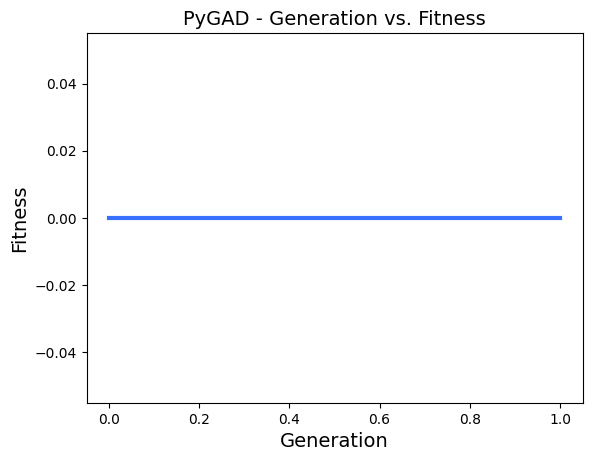

In [14]:

ga_instance, timetaken = RunGeneticAlgorithm1(boardsmall1, num_genes_small)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
PrintBoard(boardsmall1)
PrintBestSolution(solution,boardsmall1)


print("Parametry najlepszego rozwiązania :", solution)
print("Wartość fitness najlepszego rozwiązania :",solution_fitness)
print("Generacja najlepszego rozwiązania :", ga_instance.best_solution_generation+1)
print("Czas operacji :",timetaken)


p = ga_instance.plot_fitness()

### Rozdział IV

#### Algorytm genetyczny II

Algorytm genetyczny może działać lepiej, jeżeli będzie dążył nie do usunięcia wszystkich kafelków, ale do zredukowania liczby różnokolorowych pól do minimum. Będzie do tego potrzebna funkcja licząca "grupy" kafelków.

In [15]:
def CountGroups(board):
    groups = []
    for x in range (len(board[0])): # for each column
        for y in range (len(board)): # for each row
            checkedtiles = [item for sublist in groups for item in sublist]
            if board[y][x] != 0 and [y,x] not in checkedtiles: # this tile's group has not been added to groups yet
                groups.append(FindNearby(board,y,x,[]))

    return len(groups)


PrintBoard(boardsmall1)
print("Liczba jednokolorowych grup na tej planszy: ",CountGroups(boardsmall1))


 3 2 1 2 1 2 3 1
 3 1 3 2 3 2 1 1
 1 2 2 3 1 3 2 1
 1 1 1 3 2 3 2 2
 3 3 3 2 3 3 3 3
 3 1 1 2 1 2 2 3
 3 2 2 1 3 1 2 1
 3 2 3 3 3 3 2 1
Liczba jednokolorowych grup na tej planszy:  28


In [16]:
def RunGeneticAlgorithm2(board,num_genes):
    def fitness(solution, solution_id):
        newboard = [row[:] for row in board]
        groupcount = CountGroups(newboard)
        for t in solution:
            chosentile = FindTile(int(t),newboard)
            if not newboard[chosentile[0]][chosentile[1]] == 0: # if chosen tile is not empty
                removedtiles = FindNearby(newboard,chosentile[0],chosentile[1],[])
                if not len(removedtiles) == 1: # do not delete if chosen tile is a single one
                    RemoveTiles(newboard,removedtiles)
                    groupcount = CountGroups(newboard)
        return -groupcount

    starttime = time.time()
    ga_instance = pygad.GA(gene_space=GenerateGeneSpace(board),
                        num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        parent_selection_type=parent_selection_type,
                        keep_parents=keep_parents,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_percent_genes=mutation_percent_genes,
                        stop_criteria=['reach_0'])

    ga_instance.run()
    endtime = time.time()
    return ga_instance, (endtime-starttime)


Powyższy algorytm działa podobnie do tego w poprzednim rozdziale, ale funkcja **fitness** każdemu chromosomowi przypisuje ilość pozostałych grup kafelków. Zatem ponownie najlepsze rozwiązanie będzie miało wartość 0.


 3 2 1 2 1 2 3 1
 3 1 3 2 3 2 1 1
 1 2 2 3 1 3 2 1
 1 1 1 3 2 3 2 2
 3 3 3 2 3 3 3 3
 3 1 1 2 1 2 2 3
 3 2 2 1 3 1 2 1
 3 2 3 3 3 3 2 1

 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
Parametry najlepszego rozwiązania : [34.  9.  4. 56. 16.  7. 49. 16. 23. 44. 21. 32.  5. 37. 61. 34.  7. 41.
 30.  0.  8. 44. 25. 32. 27. 45. 46. 57. 11. 12. 37. 44. 30. 48. 46. 38.
 38. 39. 46. 48.]
Wartość fitness najlepszego rozwiązania : 0
Generacja najlepszego rozwiązania : 1
Czas operacji : 0.6947228908538818


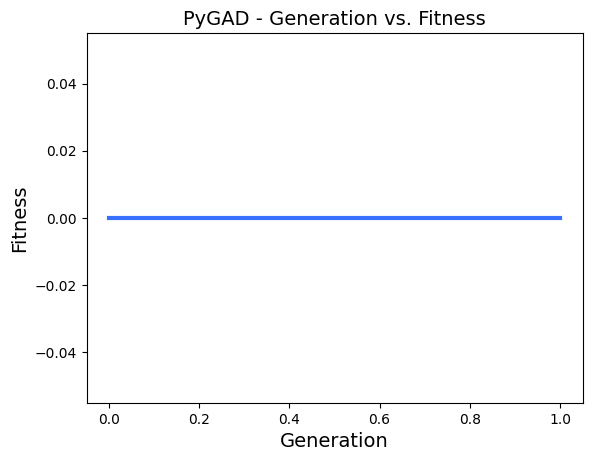

In [17]:
ga_instance, timetaken = RunGeneticAlgorithm2(boardsmall1, num_genes_small)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
PrintBoard(boardsmall1)
PrintBestSolution(solution,boardsmall1)


print("Parametry najlepszego rozwiązania :", solution)
print("Wartość fitness najlepszego rozwiązania :",solution_fitness)
print("Generacja najlepszego rozwiązania :", ga_instance.best_solution_generation+1)
print("Czas operacji :",timetaken)

p = ga_instance.plot_fitness()

### Rozdział V

#### Algorytm genetyczny III

Algorytmy z dwóch poprzednich rozdziałów działają dosyć dobrze. Warto sprawdzić, jaki wynik da ich połączenie.

In [18]:
def RunGeneticAlgorithm3(board,num_genes):

    def fitness(solution, solution_id):
        newboard = [row[:] for row in board]
        groupcount = CountGroups(newboard)
        penalty = 0
        for t in solution:
            chosentile = FindTile(int(t),newboard)
            if not newboard[chosentile[0]][chosentile[1]] == 0: # if chosen tile is not empty
                removedtiles = FindNearby(newboard,chosentile[0],chosentile[1],[])
                if not len(removedtiles) == 1: # do not delete if chosen tile is a single one
                    RemoveTiles(newboard,removedtiles)
                    newgroupcount = CountGroups(newboard)
                    if newgroupcount > groupcount:
                        penalty = penalty + 100
                    groupcount = newgroupcount

        flatboard = [t for sublist in newboard for t in sublist]
        empty = flatboard.count(0)
        tilesleft = len(flatboard) - empty
        return -(tilesleft + penalty)

    starttime = time.time()
    ga_instance = pygad.GA(gene_space=GenerateGeneSpace(board),
                        num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        parent_selection_type=parent_selection_type,
                        keep_parents=keep_parents,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_percent_genes=mutation_percent_genes,
                        stop_criteria=['reach_0'])

    ga_instance.run()
    endtime = time.time()
    return ga_instance, (endtime-starttime)

Powyższy algorytm dąży do usunięcia wszystkich kafelków, podobnie jak Algorytm I. Ponadto, utworzenie nowej grupy wiąże się z dużą karą.


 3 2 1 2 1 2 3 1
 3 1 3 2 3 2 1 1
 1 2 2 3 1 3 2 1
 1 1 1 3 2 3 2 2
 3 3 3 2 3 3 3 3
 3 1 1 2 1 2 2 3
 3 2 2 1 3 1 2 1
 3 2 3 3 3 3 2 1

 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0
Parametry najlepszego rozwiązania : [41. 16. 49. 60. 13. 33. 19. 21. 10. 57. 28. 31. 37. 40. 13. 37. 20. 46.
 37. 26. 41. 42. 22. 41.  7. 51. 22. 36. 63. 58. 10. 41. 20.  9. 40. 10.
 15. 51. 25. 57.]
Wartość fitness najlepszego rozwiązania : 0
Generacja najlepszego rozwiązania : 1
Czas operacji : 0.6258702278137207


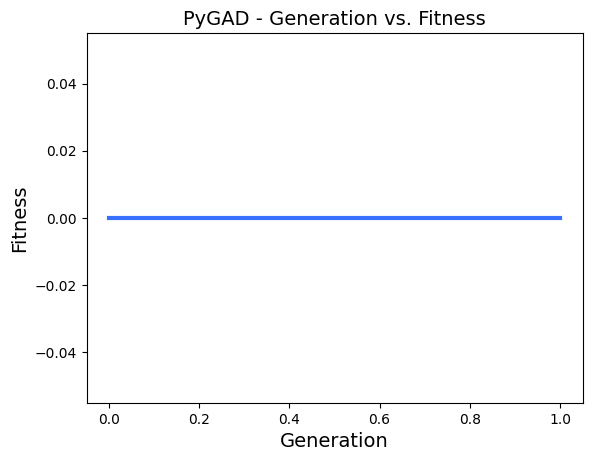

In [19]:
ga_instance, timetaken = RunGeneticAlgorithm3(boardsmall1, num_genes_small)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
PrintBoard(boardsmall1)
PrintBestSolution(solution,boardsmall1)


print("Parametry najlepszego rozwiązania :", solution)
print("Wartość fitness najlepszego rozwiązania :",solution_fitness)
print("Generacja najlepszego rozwiązania :", ga_instance.best_solution_generation+1)
print("Czas operacji :",timetaken)

p = ga_instance.plot_fitness()

### Rozdział VI

#### Porównanie wyników

Poniższa funkcja **Average** pozwala na zebranie średniej wyników wielu rozwiązań algorytmu.

In [20]:
import numpy as np

def Average(algorithm,board,num_genes,count):
    gatheredtimes = []
    gatheredfitness = []
    gatheredgenerations = []

    for i in range(count):
        ga_instance, timetaken = algorithm(board, num_genes)
        solution, solution_fitness, solution_idx = ga_instance.best_solution()
        gatheredtimes.append(timetaken)
        gatheredfitness.append(-solution_fitness)
        gatheredgenerations.append(ga_instance.best_solution_generation+1)
        print("Finished run : ",i+1,"/",count)

    print("Średni czas : ",np.average(gatheredtimes))
    print("Średnia ilość pozostałych kafelków : ",np.average(gatheredfitness))
    print("Średnia generacja : ",np.average(gatheredgenerations))

# Average(RunGeneticAlgorithm1,boardsmall1, num_genes_small, 10)

Wyniki dla dziesięciu różnych planszy w każdym wariancie prezentują się następująco<sup>1</sup>:

#### Algorytm I

| Rozmiar planszy | Liczba kolorów | Średni czas (s) | Średnia liczba pozostałych kafelków | Średni procent usuniętych kafelków | Średnia generacja najlepszego rozwiązania |
| :-: | :-: | :-: | :-: | :-: | :-: |
| mała |  3 | 0.2 | 0 | 100% | 1.1 |
| mała |  4 | 2 | 0 | 100% | 25.4 |
| mała |  5 | 11 | 0 | 100% | 125 |
| średnia |  3 | 1.3 | 0 | 100% | 4.2 |
| średnia |  4 | 10 | 0 | 100% | 32.3 |
| średnia |  5 | 84.4 | 4.6 | 96.8% | 255.1 |
| duża |  3 | 2.4 | 0 | 100% | 3.4 |
| duża |  4 | 212 | 3.4 | 98.7% | 215.5 |
| duża |  5 | 153 | 28.8 | 88.7% | 282.8 |

#### Algorytm II

| Rozmiar planszy | Liczba kolorów | Średni czas (s) | Średnia liczba pozostałych kafelków | Średni procent usuniętych kafelków | Średnia generacja najlepszego rozwiązania |
| :-: | :-: | :-: | :-: | :-: | :-: |
| mała |  3 | 0.4 | 0 | 100% | 1.2 |
| mała |  4 | 1.3 | 0 | 100% | 5.2 |
| mała |  5 | 6.8 | 0 | 100% | 22.7 |
| średnia |  3 | 2.3 | 0 | 100% | 1.3 |
| średnia |  4 | 42.4 | 0 | 100% | 25.9 |
| średnia |  5 | 884.2 | 1.3 | 99% | 208.7 |
| duża |  3 | 13.2 | 0 | 100% | 3 |
| duża |  4 | - | - | - | - |
| duża |  5 | - | - | - | - |

#### Algorytm III

| Rozmiar planszy | Liczba kolorów | Średni czas (s) | Średnia liczba pozostałych kafelków | Średni procent usuniętych kafelków | Średnia generacja najlepszego rozwiązania |
| :-: | :-: | :-: | :-: | :-: | :-: |
| mała |  3 | 0.5 | 0 | 100% | 2.1 |
| mała |  4 | 2.3 | 0 | 100% | 9.2 |
| mała |  5 | 201.6 | 1.2 | 98.1% | 72.6 |
| średnia |  3 | 2.1 | 0 | 100% | 1.1 |
| średnia |  4 | 91.4 | 0 | 100% | 40.6 |
| średnia |  5 | 923.1 | 2.3 | 96.4% | 60.2 |
| duża |  3 | 78.8 | 0 | 100% | 8.1 |
| duża |  4 | - | - | - | - |
| duża |  5 | - | - | - | - |


<sub>1) puste miejsca oznaczone symbolem '-' do obliczenia wymagają zdecydowanie większej mocy obliczeniowej niż pozwala na to maszyna autora pracy (niekiedy potrzeba ponad trzech godzin na jeden przebieg algorytmu).</sub>

(96.0, 100.1)

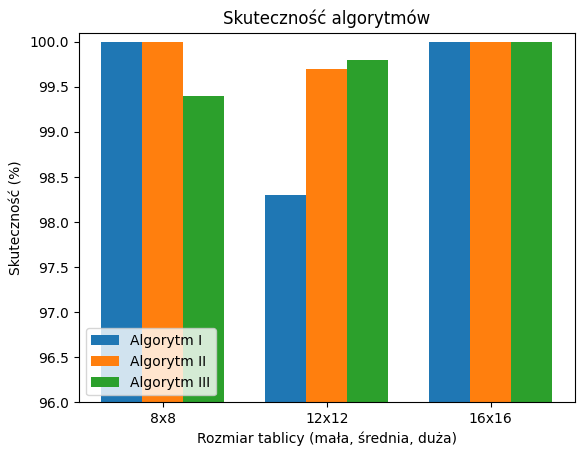

In [21]:
import matplotlib.pyplot as plt

width = 0.25
plt.bar([0,1,2], [100,98.3,100], width)
plt.bar([0+width,1+width,2+width], [100,99.7,100], width)
plt.bar([0+width*2,1+width*2,2+width*2], [99.4,99.8,100], width)
plt.title('Skuteczność algorytmów')
plt.ylabel('Skuteczność (%)')
plt.xlabel('Rozmiar tablicy (mała, średnia, duża)')
plt.xticks([0+width,1+width,2+width],['8x8','12x12','16x16'])
plt.legend(['Algorytm I', 'Algorytm II', 'Algorytm III'], loc='lower left')
plt.ylim([96,100.1])

Powyższy wykres przedstawia porównanie skuteczności trzech algorytmów w zależności od rozmiaru planszy. Brane pod uwagę jest jedynie siedem pierwszych tablic ze względu na częściowy brak danych.

Wykres ten sugeruje, że Algorytm III gorzej poradził sobie z małymi planszami, za to nieco lepiej z większymi. Natomiast Algorytm I zdecydowanie gorzej poradził sobie ze średnimi planszami.

Z pierwszą (trzykolorową) dużą planszą wszystkie algorytmy poradziły sobie równie dobrze.

Wspólną cechą wszystkich algorytmów okazała się trudność w znalezieniu rozwiązania wynikająca nie z rozmiaru planszy, a raczej z ilości kolorów.

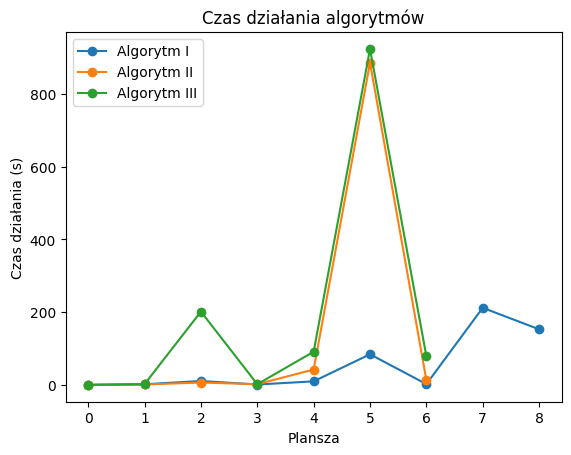

In [22]:
plt.plot([0.2, 2, 11, 1.3, 10, 84.4, 2.4, 212, 153], 'o-')
plt.plot([0.4, 1.4, 6.8, 2.3, 42.4, 885.3, 13.2], 'o-')
plt.plot([0.5, 2.3, 201.6, 2.1, 91.4, 923.1, 78.8], 'o-')
plt.title('Czas działania algorytmów')
plt.ylabel('Czas działania (s)')
plt.xlabel('Plansza')
plt.legend(['Algorytm I', 'Algorytm II', 'Algorytm III'], loc='upper left')

Czasy działania trzech algorytmów są dosyć podobne, jednak warto zauważyć dwa znaczące odstępstwa:
* Algorytm III potrzebował więcej czasu na małą planszę pięciokolorową, jednocześnie dając najgorszy wynik.
* Algorytm II oraz III potrzebowały znacząco więcej czasu na średnią planszę pięciokolorową, z czego jedynie Algorytm II dał lepszy wynik od Algorytmu I.

Z przeprowadzonych eksperymentów można wysunąć następujące wnioski:
* Algorytm I działa zdecydowanie szybciej od pozostałych, ale daje gorsze wyniki dla większych planszy.
* Algorytm II pomimo długiego czasu działania daje najlepsze wyniki.
* Algorytm III pomimo podobnego czasu działania co Algorytm II daje zdeycydowanie gorsze wyniki, co czyni go najsłabszym.

### Podsumowanie

Stosowanie algorytmu genetycznego wiąże się z pewną losowością, co sprawia, że rozwiązania mogą sięgać od bardzo prostych do niezwykle skomplikowanych, wymagających ogromu pracy po stronie komputera.

Powyższe eksperymenty wydają się dawać więcej pytań niż odpowiedzi, zwłaszcza dotyczących parametrów algorytmu genetycznego:

* Czy da się zmodyfikować algorytm, aby dokonywał wyboru w sposób "bardziej inteligentny"?
* Być może taktyka "duża populacja i mała liczba generacji", polegająca na wygenerowaniu dużej liczby chromosomów w nadziei, że jakaś część będzie dobrym rozwiązaniem byłaby bardziej efektywna niż próba naprawy małej populacji przez setki generacji?
* Czy należałoby zmienić sposób selekcji rodziców?
* Czy stosowanie nagrody w funkcji **fitness** zamiast kary dałoby lepszy wynik?
* Jak większa/mniejsza szansa na mutację genów wpłynęłaby na zachowanie algorytmu?

Jednakże znalezienie odpowiedzi na te pytania wymaga zdecydowanie większej ilości czasu oraz mocy obliczeniowej.



### Bibliografia

1. https://en.wikipedia.org/wiki/Genetic_algorithm
2. https://pl.wikipedia.org/wiki/Algorytm_genetyczny
3. https://en.wikipedia.org/wiki/SameGame
4. https://pypi.org/project/colorama/
5. https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html
6. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
7. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html